In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import datetime
from numpy.random import permutation, randint
import matplotlib.pyplot as plt

## Define the masked layer

In [ ]:
class MaskedLinear1(nn.Linear):
  def __init__(self, input_dim, output_dim, bias=True):
    super().__init__(input_dim, output_dim, bias)
    self.mask = self.register_buffer('mask', torch.zeros_like(self.weight))

  def _init_mask(self, mask):
    self.mask = mask

  def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)

## Masked Autoencoder

In [ ]:
class MaskedAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dims, output_dim, device='cpu'):
    super(MaskedAutoencoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.device = device
    # hidden_dims is a list of hidden dimensions of hidden layers.
    self.layers = nn.ModuleList()
    self.layers += [MaskedLinear1(input_dim, hidden_dims[0])]
    for i in range(len(hidden_dims)-1):
      self.layers += [MaskedLinear1(hidden_dims[i], hidden_dims[i+1])]
    self.layers += [MaskedLinear1(hidden_dims[-1], output_dim)]

    self.m_l_k = self.calculate_m_k_l(input_dim, hidden_dims, output_dim) # units in layer l th connected to at most ml[l] inputs. l=0 means input layer
    self.mask = self.create_masks(self.m_l_k) # mask mastrices
    self.loss_values = []


  def calculate_m_k_l(self, input_dim, hidden_dims, output_dim):
    """
      To create mask for each layer, we need to calculate the maximum number of inputs that connects to a unit in each layer.
    """
    D = input_dim
    L = len(hidden_dims)

    m_l_k = []
    # Create the ordered vector [1, ..., D]
    # m_l_k.append(permutation(D)) # calculate m_0_k
    m_l_k.append(np.arange(D))

    # calculate m_l_k for hidden layers
    # m_l_k ~ uniform(1, D -1) but sometimes, to avoid unconnected units, the value for m_l_k is sampled to be greater than or equal to the minimum connectivity at the previous layer.
    for i in range(1, L+1):
      low = m_l_k[i-1].min()
      high = D-1
      m_l_k.append(randint(low, high, size=hidden_dims[i-1]))

    # m_l_k for the output layer
    m_l_k.append(m_l_k[0]) # the same with the input layer
    return m_l_k


  def create_masks(self, m_l_k):
    """
      Calculate each mask for each layers.
    """
    mask = []
    # calculate W_L for hidden layers first
    for l in range(1, len(m_l_k) -1):
      mask_matrix = np.zeros((m_l_k[l].shape[0], m_l_k[l-1].shape[0])) # layer_l_dim, layer_l-1_dim
      for i in range(m_l_k[l].shape[0]):
        mask_matrix[i] = np.array(m_l_k[l][i] >= m_l_k[l-1])
      mask.append(torch.tensor(mask_matrix).float().to(self.device))

    # calculate mask for the last hidden layer - output layer
    mask_matrix = np.zeros((m_l_k[-1].shape[0], m_l_k[-2].shape[0]))
    for i in range(m_l_k[-1].shape[0]):
      mask_matrix[i] = np.array(m_l_k[-1][i] > m_l_k[-2])
    mask.append(torch.tensor(mask_matrix).float().to(self.device))

    # init mask for layer
    for i in range(len(self.layers)):
      self.layers[i]._init_mask(mask[i])

    return mask

  def forward(self, x):
    for i in range(len(self.layers)-1):
      x = self.layers[i](x)
      x = F.relu(x)
    x = self.layers[-1](x)
    x = torch.sigmoid(x)
    return x # batch, channels*height*width

  def loss_function(self, y, x):
    return F.binary_cross_entropy(y, x)

  def sample(self, n):
    samples = torch.rand(n, self.input_dim).to(self.device)
    with torch.no_grad():
      for i in range(self.output_dim):
        probs = self.forward(samples)[:, i]
        samples[:, i] = torch.bernoulli(probs)

    return samples.cpu().numpy()

## Data set

In [ ]:
def get_data_loaders(batch_size, data_set = "mnist"):
    """
        This function returns the train and test data loaders for the specified data set.
        For now, this function can work with MNIST, CIFAR-10, and Fashion-MNIST data sets.
    """

    assert data_set in ["mnist", "cifar10", "fashionmnist"], "data_set should be one of the following: mnist, cifar10, fashionmnist."
    if data_set == "mnist":
        transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.round())])
        train_set = torchvision.datasets.MNIST(root='./data',
                                                train=True,
                                                download=True,
                                                transform=transform) # binarized MNIST
        test_set = torchvision.datasets.MNIST(root='./data',
                                                train=False,
                                                download=True,
                                                transform=transform)
    elif data_set == "cifar10":
        train_set = torchvision.datasets.CIFAR10(root='./data',
                                                train=True,
                                                download=True,
                                                transform=transforms.ToTensor())
        test_set = torchvision.datasets.CIFAR10(root='./data',
                                                train=False,
                                                download=True,
                                                transform=transforms.ToTensor())
    elif data_set == "fashionmnist":
        train_set = torchvision.datasets.FashionMNIST(root='./data',
                                                train=True,
                                                download=True,
                                                transform=transforms.ToTensor())
        test_set = torchvision.datasets.FashionMNIST(root='./data',
                                                train=False,
                                                download=True,
                                                transform=transforms.ToTensor())


    train_loader = torch.utils.data.DataLoader(train_set,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=2)

    return train_loader, test_loader

## Training pipeline

In [ ]:
  # training pipeline
def train_model(model, optimizer, train_loader, epochs, device):
  device = device
  for epoch in range(epochs):
    for i, (images, label) in enumerate(train_loader):
      x = images.to(device) # batch, channels, height, width
      x = x.view(x.shape[0], -1) # batch, channels*height*width
      optimizer.zero_grad() # batch, channels*height*width

      y = model(x)

      loss = model.loss_function(y, x)

      loss.backward()
      optimizer.step()
      model.loss_values.append(loss.item()) # save loss value

      if (i+1) % 100 == 0:
          print("Epoch [{}/{}], Step [{}/{}]: {:.4f}, Time: {}".format(epoch+1, epochs, i+1, len(train_loader), loss.item(), datetime.datetime.now()))


def train_epoch(model, train_loader, epoch, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    for i, (images, label) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.reshape(-1, 28 * 28).float().to(model.device)
        x_hat = model.forward(images)

        binary_loss = F.binary_cross_entropy(
            x_hat, images.reshape(-1, 28 * 28), reduction="sum"
        )

        binary_loss.backward()
        loss = binary_loss.item()
        model.loss_values.append(loss)
        train_loss += loss
        optimizer.step()
        if scheduler:
            scheduler.step(epoch)

    avg_loss = train_loss / len(train_loader.dataset)
    print("(Epoch {}) Average loss: {:.4f}".format(str(epoch).zfill(3), avg_loss))

## Init the model

In [ ]:
height = 28
width = 28
channels = 1
batch_size = 128
data_set = 'mnist'
hidden_dims = [520, 520, 520]
learning_rate = 0.01

train_loader, test_loader = get_data_loaders(batch_size, data_set)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MaskedAutoencoder(channels*height*width, hidden_dims,channels*height*width, device).to(device)
print(model)

MaskedAutoencoder(
  (layers): ModuleList(
    (0): MaskedLinear1(in_features=784, out_features=520, bias=True)
    (1-2): 2 x MaskedLinear1(in_features=520, out_features=520, bias=True)
    (3): MaskedLinear1(in_features=520, out_features=784, bias=True)
  )
)


## Train and test the model

Epoch [1/20], Step [100/469]: 0.2585, Time: 2023-05-24 04:43:50.489605
Epoch [1/20], Step [200/469]: 0.2489, Time: 2023-05-24 04:43:53.763822
Epoch [1/20], Step [300/469]: 0.2462, Time: 2023-05-24 04:43:56.055328
Epoch [1/20], Step [400/469]: 0.2416, Time: 2023-05-24 04:43:58.056990
Epoch [2/20], Step [100/469]: 0.2296, Time: 2023-05-24 04:44:01.586754
Epoch [2/20], Step [200/469]: 0.2313, Time: 2023-05-24 04:44:03.768121
Epoch [2/20], Step [300/469]: 0.2383, Time: 2023-05-24 04:44:06.558466
Epoch [2/20], Step [400/469]: 0.2272, Time: 2023-05-24 04:44:08.522036
Epoch [3/20], Step [100/469]: 0.2210, Time: 2023-05-24 04:44:11.983626
Epoch [3/20], Step [200/469]: 0.2217, Time: 2023-05-24 04:44:14.001036
Epoch [3/20], Step [300/469]: 0.2250, Time: 2023-05-24 04:44:16.042522
Epoch [3/20], Step [400/469]: 0.2226, Time: 2023-05-24 04:44:18.924678
Epoch [4/20], Step [100/469]: 0.2164, Time: 2023-05-24 04:44:22.392209
Epoch [4/20], Step [200/469]: 0.2191, Time: 2023-05-24 04:44:24.438449
Epoch 

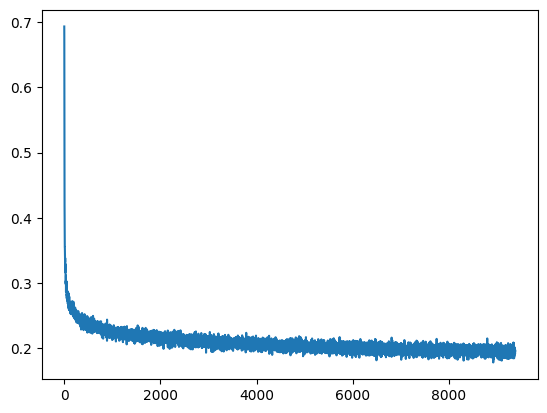

In [ ]:
epochs = 20
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=0.0001, eps=1e-6)
# for epoch in range(epochs):
#   train_epoch(model, train_loader, epoch, optimizer)
train_model(model, optimizer, train_loader, epochs, device)
# save the model
torch.save(model.state_dict(), '/content/rnn.pth')
plt.plot(model.loss_values)
plt.show()

In [ ]:
print(model.loss_values[-1])

0.19623948633670807


[]

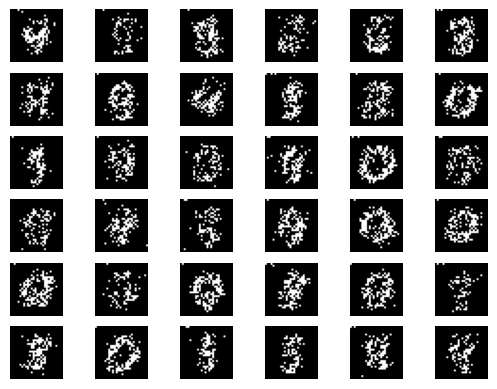

In [ ]:
imgs = model.sample(36)

for i in range(36):
  img = imgs[i].reshape(28, 28)
  plt.subplot(6, 6, i+1)
  plt.imshow(img,cmap='gray')
  plt.axis('off')

plt.plot()

In [ ]:
torch.save(model.state_dict(), 'MADE.pth')